<a href="https://colab.research.google.com/github/doduyquy/NLP_Machine-Translation-LSTM/blob/main/%5BNotGood%5DV4_20.000_test2016_vocabs_nlp-machinetranslation-en-fr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.9.0+cu126
True
Tesla T4


In [2]:
!pip install spacy nltk sentencepiece --user
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 143.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 78.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1. IMPORT LIBS, DEPENDENCIES,... & SETUP ENVIRONMENT

## 1.1 Import all necessary dependencies

In [4]:
import spacy

# Subword
import sentencepiece as spm

# Build vocabulary
# from collections import Counter # No longer needed for custom Vocab

# Build model
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset for model
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# BLEU score
from nltk.translate.bleu_score import sentence_bleu

# Another (utils)
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"- Device for training: {device} - {torch.cuda.get_device_name(0)}")

- Device for training: cuda - Tesla T4


## 1.2 Connect to GG Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

# Show the result
dataset_path = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
!ls "$dataset_path"

Mounted at /content/drive/
test_2016.en  test_2017.en  test.en  train.en  val.en
test_2016.fr  test_2017.fr  test.fr  train.fr  val.fr


## 1.3 Set constant

In [6]:
GGDRIVE_DATASET_DIR_PATH = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
GGDRIVE_MODEL_DIR_PATH = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Model/"
# ----------------------------------------
""" [4] Build vocab
- <pad> - 0: padding, add to short sentences to have the same length with long sentences in Batch
- <unk> - 1: unknown, index for some unknown words (token)
- <sos> - 2: start of sentence
- <eos> - 3: end of sentence
"""
SPECIAL_TOKENS_CONST = ["<pad>", "<unk>", "<sos>", "<eos>"]
# VOCAB_MAX_SIZE_CONST = 10000  # 10.000 most common words
VOCAB_MAX_SIZE_CONST = 20000  # 20.000 most common words -> fix OOV error


#----- Change for optimize model -----#
#--- [DEFAULT] ~ [BASELINE]
# [5] Dataset & DataLoader
TRAIN_LOADER_BATCH_SIZE_DEFAULT     =   32
# [6] LSTM layers
LSTM_NUM_LAYERS_DEFAULT             =   2
LSTM_DROPOUT_DEFAULT                =   0.3
LSTM_TEACHER_FORCING_DEFAULT        =   0.5
LSTM_EMBED_DIM_DEFAULT              =   256
LSTM_HIDDEN_DIM_DEFAULT             =   512
# [7] TRAINING + VALIDATION + EARLY STOPPING
MODEL_LEARNING_RATE_DEFAULT         =   0.001
MODEL_EPOCHS_DEFAULT                =   20
MODEL_EARLY_STOP_PATIENCE_DEFAULT   =   3

#--- [V1: deeper LSTM layers]
# ...
# ...

#--- CURRENT ---#
TRAIN_LOADER_BATCH_SIZE_CURRENT = TRAIN_LOADER_BATCH_SIZE_DEFAULT
LSTM_NUM_LAYERS_CURRENT = LSTM_NUM_LAYERS_DEFAULT
LSTM_DROPOUT_CURRENT = LSTM_DROPOUT_DEFAULT
LSTM_TEACHER_FORCING_CURRENT = LSTM_TEACHER_FORCING_DEFAULT
LSTM_EMBED_DIM_CURRENT = LSTM_EMBED_DIM_DEFAULT
LSTM_HIDDEN_DIM_CURRENT = LSTM_HIDDEN_DIM_DEFAULT
MODEL_LEARNING_RATE_CURRENT = MODEL_LEARNING_RATE_DEFAULT
MODEL_EPOCHS_CURRENT = MODEL_EPOCHS_DEFAULT
MODEL_EARLY_STOP_PATIENCE_CURRENT = MODEL_EARLY_STOP_PATIENCE_DEFAULT
#-------------------------------------#




# 2. LOAD DATA

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

# Show the result
dataset_path = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
# dataset_path = "./data"
!ls "$dataset_path"

def load_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        # Remove abundant space at head/tail
        return [line.strip() for line in file]

train_en = load_file(f"{dataset_path}/train.en")
train_fr = load_file(f"{dataset_path}/train.fr")

val_en = load_file(f"{dataset_path}/val.en")
val_fr = load_file(f"{dataset_path}/val.fr")

test_en = load_file(f"{dataset_path}/test.en")
test_fr = load_file(f"{dataset_path}/test.fr")
# test_en = load_file(f"{dataset_path}/test_2016.en")
# test_fr = load_file(f"{dataset_path}/test_2016.fr")

print(f"- train.en size:    {len(train_en)}")
print(f"- train.fr size:    {len(train_fr)}")

print(f"- val.en size:    {len(val_en)}")
print(f"- val.fr size:    {len(val_fr)}")

print(f"- test.en size:    {len(test_en)}")
print(f"- test.fr size:    {len(test_fr)}")

print("-"*69)
print(f"- train.en example: {train_en[0]}")
print(f"- train.fr example: {train_fr[0]}")



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
test_2016.en  test_2017.en  test.en  train.en  val.en
test_2016.fr  test_2017.fr  test.fr  train.fr  val.fr
- train.en size:    29000
- train.fr size:    29000
- val.en size:    1014
- val.fr size:    1014
- test.en size:    1071
- test.fr size:    1071
---------------------------------------------------------------------
- train.en example: Two young, White males are outside near many bushes.
- train.fr example: Deux jeunes hommes blancs sont dehors près de buissons.


# 3. TOKENIZATION

In [8]:
# Load spacy's pre-trained models (will still be used for initial text preprocessing before BPE)
nlp_en = spacy.load("en_core_web_sm")   # small English core, train with data in the internet
nlp_fr = spacy.load("fr_core_news_sm")  # small French core, train with news in French language

def en_tokenizer(text):
    # return lower token
    return [tok.text.lower() for tok in nlp_en.tokenizer(text)]
def fr_tokenizer(text):
    return [tok.text.lower() for tok in nlp_fr.tokenizer(text)]

# Define the train_bpe function
def train_bpe(texts, vocab_size=VOCAB_MAX_SIZE_CONST, model_prefix="bpe", special_tokens=SPECIAL_TOKENS_CONST):
    with open("temp_corpus.txt", "w", encoding="utf-8") as f:
        for text in texts:
            f.write(text + "\n")

    # Arguments for sentencepiece training, mapping special tokens to specific IDs
    args = [
        f"--input=temp_corpus.txt",
        f"--model_prefix={model_prefix}",
        f"--vocab_size={vocab_size}",
        f"--model_type=bpe",
        f"--pad_id=0", # <pad> token index
        f"--unk_id=1", # <unk> token index
        f"--bos_id=2", # <sos> token index
        f"--eos_id=3", # <eos> token index
        # Add any other user-defined symbols if needed, beyond the automatically handled ones
        # For SPECIAL_TOKENS_CONST, all are covered by pad_id, unk_id, bos_id, eos_id
    ]
    spm.SentencePieceTrainer.train(" ".join(args))

    return spm.SentencePieceProcessor(model_file=f"{model_prefix}.model")

In [26]:
# Tokenize our dataset files: train_en, train_fr, val_en, val_fr, test_en, test_fr.
# These spacy-tokenized lists are kept for BLEU evaluation reference but not for model input anymore.

train_en_tok = [en_tokenizer(sentence) for sentence in train_en]
train_fr_tok = [fr_tokenizer(sentence) for sentence in train_fr]

val_en_tok = [en_tokenizer(sentence) for sentence in val_en]
val_fr_tok = [fr_tokenizer(sentence) for sentence in val_fr]

test_en_tok = [en_tokenizer(sentence) for sentence in test_en]
test_fr_tok = [fr_tokenizer(sentence) for sentence in test_fr]


# Train SentencePiece BPE models
sp_en = train_bpe(train_en, vocab_size=VOCAB_MAX_SIZE_CONST, model_prefix="bpe_en", special_tokens=SPECIAL_TOKENS_CONST)
sp_fr = train_bpe(train_fr, vocab_size=VOCAB_MAX_SIZE_CONST, model_prefix="bpe_fr", special_tokens=SPECIAL_TOKENS_CONST)

# Get special token IDs from the trained SentencePiece model
PAD_IDX = sp_fr.pad_id()
UNK_IDX = sp_fr.unk_id()
SOS_IDX = sp_fr.bos_id()
EOS_IDX = sp_fr.eos_id()

print(f"BPE EN vocabulary size: {sp_en.get_piece_size()}")
print(f"BPE FR vocabulary size: {sp_fr.get_piece_size()}")
print(f"- <pad> index: {PAD_IDX}")
print(f"- <unk> index: {UNK_IDX}")
print(f"- <sos> index: {SOS_IDX}")
print(f"- <eos> index: {EOS_IDX}")

BPE EN vocabulary size: 20000
BPE FR vocabulary size: 20000
- <pad> index: 0
- <unk> index: 1
- <sos> index: 2
- <eos> index: 3


In [27]:
print(f"- train_en_tok (spacy): {train_en_tok[0]}")
print(f"- train_fr_tok (spacy): {train_fr_tok[0]}")
print(f"- val_en_tok (spacy): {val_en_tok[0]}")
print(f"- val_fr_tok (spacy): {val_fr_tok[0]}")
print(f"- test_en_tok (spacy): {test_en_tok[0]}")
print(f"- test_fr_tok (spacy): {test_fr_tok[0]}")

# Example of SentencePiece tokenization
print(f"- train.en example (BPE tokens): {sp_en.encode_as_pieces(train_en[0])}")
print(f"- train.fr example (BPE tokens): {sp_fr.encode_as_pieces(train_fr[0])}")
print(f"- train.en example (BPE IDs): {sp_en.encode_as_ids(train_en[0], add_bos=True, add_eos=True)}")
print(f"- train.fr example (BPE IDs): {sp_fr.encode_as_ids(train_fr[0], add_bos=True, add_eos=True)}")

- train_en_tok (spacy): ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
- train_fr_tok (spacy): ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
- val_en_tok (spacy): ['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
- val_fr_tok (spacy): ['un', 'groupe', "d'", 'hommes', 'chargent', 'du', 'coton', 'dans', 'un', 'camion']
- test_en_tok (spacy): ['a', 'young', 'man', 'participates', 'in', 'a', 'career', 'while', 'the', 'subject', 'who', 'records', 'it', 'smiles', '.']
- test_fr_tok (spacy): ['un', 'jeune', 'homme', 'participe', 'à', 'une', 'course', 'pendant', 'que', 'le', 'sujet', 'qui', 'le', 'filme', 'sourit', '.']
- train.en example (BPE tokens): ['▁Two', '▁young', ',', '▁White', '▁males', '▁are', '▁outside', '▁near', '▁many', '▁bushes', '.']
- train.fr example (BPE tokens): ['▁Deux', '▁jeunes', '▁hommes', '▁blancs', '▁sont', '▁dehors', '▁près', '▁de', '▁buissons', '.']
- train

# 4. BUILD VOCABULARY

In [28]:
# The custom Vocab class is no longer needed as SentencePiece handles vocabulary and numericalization directly.

In [29]:
# The print statements for the custom Vocab class are no longer relevant.

# 5. DATASET & DATALOADER


In [30]:
class TranslationDataset(Dataset):
    def __init__(self, en_sentences, fr_sentences, sp_en, sp_fr):
        self.en = en_sentences # Raw English sentences
        self.fr = fr_sentences # Raw French sentences
        self.sp_en = sp_en     # SentencePieceProcessor for English
        self.sp_fr = sp_fr     # SentencePieceProcessor for French

    def __len__(self):
        return len(self.en)

    def __getitem__(self, idx):
        # Encode sentences directly using SentencePieceProcessor
        # add_bos=True, add_eos=True will add <bos> and <eos> tokens with their configured IDs
        en_idx = self.sp_en.encode_as_ids(self.en[idx], add_bos=True, add_eos=True)
        fr_idx = self.sp_fr.encode_as_ids(self.fr[idx], add_bos=True, add_eos=True)

        # return a tuple of tensor indices
        return torch.tensor(en_idx), torch.tensor(fr_idx)

In [31]:

# Padding for short sentences in each batch
def collate_fn_baseline(batch):
    # Split sequence to english sentence and french sentence
    en_batch, fr_batch = zip(*batch)

    """ Padding:
        1. Find the max length
        2. Insert <pad> - 0 to the tail of short sentences. e.g:
            First 1: [1, 10, 11, 12, 2] (keep, the longest sentence)
            Second 2: [1, 13, 2, **0**, **0**] (append two <pad>-0)
        3. Stacking (by columns: column - batch, row - timestep)
                    1   1
                    10  13
                    11  2
                    12  0
                    2   0
    """
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX)

    return en_batch, fr_batch

# Add pack_padded_sequence and sort batch desc by length
def collate_fn(batch):
    # Split sequence to english sentence and french sentence
    en_batch, fr_batch = zip(*batch)

    # 1. Get real length before padding
    en_lens = torch.tensor([len(x) for x in en_batch])
    fr_lens = torch.tensor([len(x) for x in fr_batch])

    # 2. Sort by english length (desc) - required for pack_padded_sequence
    en_lens, sort_idx = en_lens.sort(descending=True)
    en_batch = [en_batch[i] for i in sort_idx]
    fr_batch = [fr_batch[i] for i in sort_idx]
    fr_lens = fr_lens[sort_idx] # sort french math with english

    # 3. Padding
    en_pad = pad_sequence(en_batch, padding_value=PAD_IDX)
    fr_pad = pad_sequence(fr_batch, padding_value=PAD_IDX)

    # 4. Return padded sequence and real length
    return en_pad, fr_pad, en_lens, fr_lens


In [32]:
train_dataset = TranslationDataset(train_en, train_fr, sp_en, sp_fr)
val_dataset = TranslationDataset(val_en, val_fr, sp_en, sp_fr)
test_dataset = TranslationDataset(test_en, test_fr, sp_en, sp_fr)


# For train dataset, we should shuffle it to avoid overfitting.
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_LOADER_BATCH_SIZE_CURRENT,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_LOADER_BATCH_SIZE_CURRENT,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

In [33]:
# shape: [Sequence_Length, Batch_Size], because LSTM/RNN in Pytorch handle data by timestep
batch_train_en, batch_train_fr, batch_train_en_lens, batch_train_fr_lens = next(iter(train_loader))
batch_val_en, batch_val_fr, batch_val_en_lens, batch_val_fr_lens = next(iter(val_loader))
batch_test_en, batch_test_fr, batch_test_en_lens, batch_test_fr_lens = next(iter(test_loader))

print(f"Train - EN: {batch_train_en.shape}, FR: {batch_train_fr.shape}")
print(f"Train - EN lens: {batch_train_en_lens}, FR lens: {batch_train_fr_lens}")
print()
print(f"Val - EN: {batch_val_en.shape}, FR: {batch_val_fr.shape}")
print(f"Val - EN lens: {batch_val_en_lens}, FR lens: {batch_val_fr_lens}")
print()
print(f"Test - EN: {batch_test_en.shape}, FR: {batch_test_fr.shape}")
print(f"Test - EN lens: {batch_test_en_lens}, FR lens: {batch_test_fr_lens}")

Train - EN: torch.Size([28, 32]), FR: torch.Size([33, 32])
Train - EN lens: tensor([28, 26, 22, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 16, 15, 15, 15, 14,
        14, 14, 14, 14, 14, 13, 13, 11, 11, 11, 10,  8,  7,  6]), FR lens: tensor([29, 33, 29, 19, 22, 19, 18, 24, 19, 21, 25, 17, 18, 14, 13, 15, 14, 17,
        16, 18, 16, 15, 16, 18, 20, 13, 10, 13, 10, 15,  8, 10])

Val - EN: torch.Size([28, 32]), FR: torch.Size([30, 32])
Val - EN lens: tensor([28, 20, 20, 19, 18, 18, 17, 17, 17, 16, 16, 16, 15, 15, 14, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11]), FR lens: tensor([30, 24, 18, 26, 28, 19, 25, 20, 14, 17, 21, 16, 15, 17, 17, 15, 11, 11,
        19, 14, 13, 16, 15, 13, 12, 13, 11, 11, 11, 11, 11, 11])

Test - EN: torch.Size([18, 1]), FR: torch.Size([18, 1])
Test - EN lens: tensor([18]), FR lens: tensor([18])


# Attention

In [34]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, decoder_hidden, encoder_outputs):
        """
        decoder_hidden: [num_layers, batch, hidden]
        encoder_outputs: [src_len, batch, hidden]
        """
        # lấy hidden của layer cuối: [batch, hidden]
        decoder_hidden = decoder_hidden[-1].unsqueeze(2)  # [batch, hidden, 1]

        # Score = encoder_output · decoder_hidden
        # encoder_outputs: [src_len, batch, hidden]
        # sau permute:    [batch, src_len, hidden]
        scores = torch.bmm(
            encoder_outputs.permute(1,0,2),
            decoder_hidden
        ).squeeze(2)  # [batch, src_len]

        attn_weights = torch.softmax(scores, dim=1)  # [batch, src_len]

        return attn_weights


# 6. ENCODER-DECODER, SEQ2SEQ MODEL

In [35]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=LSTM_NUM_LAYERS_DEFAULT, dropout=LSTM_DROPOUT_DEFAULT):
        super().__init__()

        # src shape e.g: [10, 32] - [Sequence_length, Batch_size]
        """ embed_dim: vector size for each word
            - Create matrix (A) with shape: [vocab_size, embed_dim], each row represent for each word,
            e.g: src shape: [10, 32], elements are the index of words in vocab, so we get the row of that index in matrix (A)
            - Result: a matrix with shape [10, 32, 256]
        """
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        """ hidden_dim: vector size for hidden state
            - Result: e.g [10, 32, 512]
        """
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=num_layers,  # use num_layers(2) layers LSTM
                            dropout=dropout)    # randomly turn off neuron to avoid overfitting

    def forward(self, src, src_lens):
        # src: [seq_len, batch_size]
        # src_len: [batch_size] - sorted (desc)

        embedded = self.embedding(src)

        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            src_lens.cpu(), # require length at CPU
            enforce_sorted=True
        )
        # LSTM forward
        packed_outputs, (hidden, cell) = self.lstm(packed)
        # Unpack
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=LSTM_NUM_LAYERS_DEFAULT, dropout=LSTM_DROPOUT_DEFAULT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout)
        # Attention module
        self.attention = LuongAttention(hidden_dim)

        # Fully connected - input size is hidden_dim * 2 (context + decoder output)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input: a word
        # encoder_outputs: [src_len, batch, hidden]
        input = input.unsqueeze(0)
        embedded = self.embedding(input)

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        # Apply attention: output shape [batch, hidden]
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch, src_len]

        # Context vector: weighted sum of encoder outputs
        # attn_weights: [batch, src_len] -> [batch, 1, src_len]
        # encoder_outputs: [src_len, batch, hidden] -> [batch, src_len, hidden]
        context = torch.bmm(
            attn_weights.unsqueeze(1),  # [batch, 1, src_len]
            encoder_outputs.permute(1, 0, 2)  # [batch, src_len, hidden]
        ).squeeze(1)  # [batch, hidden]

        # Concatenate context and decoder output
        combined = torch.cat([output.squeeze(0), context], dim=1)  # [batch, hidden*2]

        # prediction shape: [batch, vocab_size]
        prediction = self.fc(combined)

        return prediction, hidden, cell, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, src_lens, teacher_forcing=LSTM_TEACHER_FORCING_DEFAULT):
        # src (en): [src_len, batch_size]
        # trg (fr): [trg_len, batch_size]
        # src_lens: [batch_size]

        batch_size = trg.size(1)
        max_len = trg.size(0)
        vocab_size = self.decoder.fc.out_features

        # a zero tensor (default) contain output
        outputs = torch.zeros(max_len, batch_size, vocab_size).to(src.device)

        #--- Get Context Vector from Encoder:
        encoder_outputs, hidden, cell = self.encoder(src, src_lens)

        # token <sos>
        input_token = trg[0, :]

        for timestep in range(1, max_len):
            output, hidden, cell, _ = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[timestep] = output

            best_guess = output.argmax(1)

            # teacher_forcing:
            # random < teacher_forcing ratio: trg[timestep], the true target
            # random >= teacher_forcing ratio: the best_guess
            input_token = trg[timestep] if random.random() < teacher_forcing else best_guess

        return outputs

# 7. TRAINING + VALIDATION + EARLY STOPPING

In [36]:
start_time = time.perf_counter()


input_dim = sp_en.get_piece_size() # Get vocabulary size from SentencePiece
output_dim = sp_fr.get_piece_size() # Get vocabulary size from SentencePiece
# print(input_dim, output_dim)

encoder = Encoder(vocab_size=input_dim, embed_dim=LSTM_EMBED_DIM_CURRENT, hidden_dim=LSTM_HIDDEN_DIM_CURRENT, num_layers=LSTM_NUM_LAYERS_CURRENT).to(device)  # 256, 512
decoder = Decoder(vocab_size=output_dim, embed_dim=LSTM_EMBED_DIM_CURRENT, hidden_dim=LSTM_HIDDEN_DIM_CURRENT, num_layers=LSTM_NUM_LAYERS_CURRENT).to(device)  # 256, 512

model = Seq2Seq(encoder, decoder).to(device)

# Ignore computing loss for PAD_IDX
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(params=model.parameters(), lr=MODEL_LEARNING_RATE_CURRENT)

def evaluate(model, loader):
    model.eval()
    total = 0
    # torch.no_grad(): remove old gradient
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in loader:
            src, trg = src.to(device), trg.to(device)
            src_lens = src_lens.to(device)

            outputs = model(src, trg, src_lens, teacher_forcing=LSTM_TEACHER_FORCING_CURRENT)

            loss = criterion(outputs[1:].reshape(-1, outputs.size(-1)),
                             trg[1:].reshape(-1))

            total += loss.item()

    return total / len(loader)

best_val = float("inf")
best_state_dict = None
best_epoch = -1
wait = 0

val_loss_arr = []
train_loss_arr = []

for epoch in range(MODEL_EPOCHS_CURRENT):
    model.train()
    total_loss = 0

    for src, trg, src_lens, trg_lens in tqdm(train_loader):
        src, trg = src.to(device), trg.to(device)
        src_lens = src_lens.to(device)

        optimizer.zero_grad()
        outputs = model(src, trg, src_lens) # Update

        loss = criterion(outputs[1:].reshape(-1, outputs.size(-1)),
                        trg[1:].reshape(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    print(f"Epoch {epoch + 1} | Train = {train_loss:.4f} | Val = {val_loss:.4f}\n")

    if val_loss < best_val:
        best_val = val_loss
        best_state_dict = model.state_dict()
        best_epoch = epoch
        wait = 0
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= MODEL_EARLY_STOP_PATIENCE_CURRENT:
            print("\n[X] Early stopping triggered!\n")
            break

# Save the best model
torch.save(best_state_dict, "best_model.pth")
print(f"- Best model saved at epoch {best_epoch+1}, val_loss={best_val:.4f}")

end_time = time.perf_counter()
print(f"--- DONE ---\n- Total training time: {end_time- start_time:.2f} seconds.")

100%|██████████| 907/907 [03:11<00:00,  4.73it/s]


Epoch 1 | Train = 4.2932 | Val = 3.4607



100%|██████████| 907/907 [03:12<00:00,  4.71it/s]


Epoch 2 | Train = 2.7419 | Val = 2.6639



100%|██████████| 907/907 [03:11<00:00,  4.74it/s]


Epoch 3 | Train = 2.0789 | Val = 2.3793



100%|██████████| 907/907 [03:12<00:00,  4.71it/s]


Epoch 4 | Train = 1.6975 | Val = 2.3647



100%|██████████| 907/907 [03:11<00:00,  4.72it/s]


Epoch 5 | Train = 1.4140 | Val = 2.2895



100%|██████████| 907/907 [03:11<00:00,  4.73it/s]


Epoch 6 | Train = 1.2019 | Val = 2.3506



100%|██████████| 907/907 [03:12<00:00,  4.72it/s]


Epoch 7 | Train = 1.0434 | Val = 2.2539



100%|██████████| 907/907 [03:12<00:00,  4.71it/s]


Epoch 8 | Train = 0.9484 | Val = 2.3197



100%|██████████| 907/907 [03:11<00:00,  4.73it/s]


Epoch 9 | Train = 0.8468 | Val = 2.3813



100%|██████████| 907/907 [03:12<00:00,  4.71it/s]


Epoch 10 | Train = 0.7644 | Val = 2.3033


[X] Early stopping triggered!

- Best model saved at epoch 7, val_loss=2.2539
--- DONE ---
- Total training time: 1947.29 seconds.


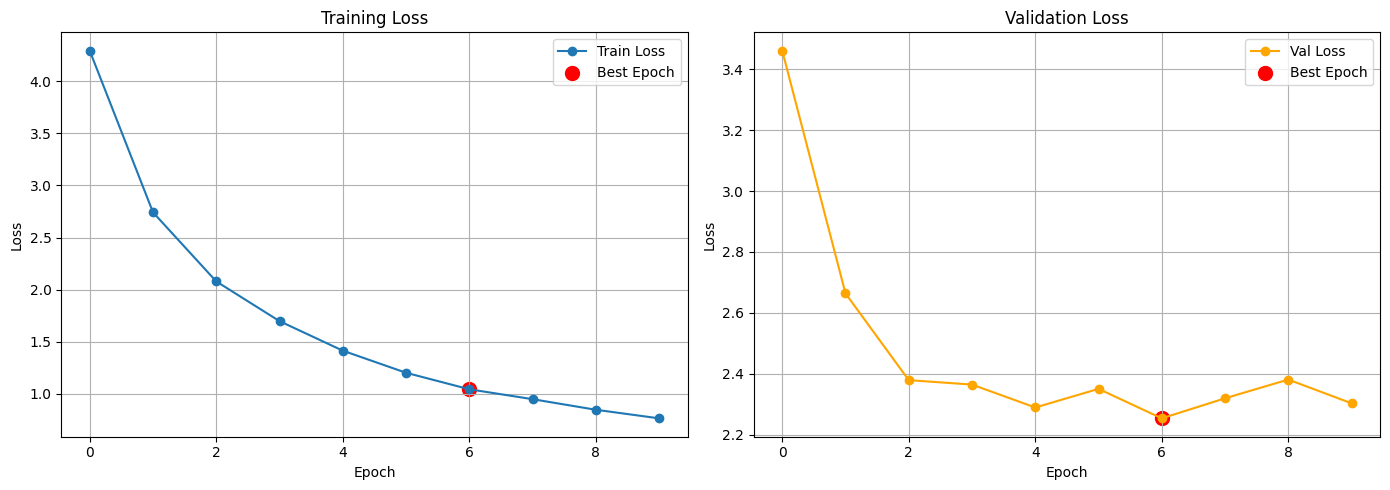

In [39]:
plt.figure(figsize=(14, 5))

# 1. Train Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_arr, marker='o', label="Train Loss")
plt.scatter(best_epoch, train_loss_arr[best_epoch], color='red', s=100,
            label="Best Epoch")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 2. Validation Loss Plot
plt.subplot(1, 2, 2)
plt.plot(val_loss_arr, color='orange', marker='o', label="Val Loss")
plt.scatter(best_epoch, val_loss_arr[best_epoch], color='red', s=100,
            label="Best Epoch")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# 8. TRANSLATE + BLEU SCORE

In [40]:
def translate(sentence):
    model.eval()

    # Encode the input sentence to numerical IDs using the English SentencePiece model
    # add_bos=True and add_eos=True will automatically add the start and end of sentence tokens
    ids = sp_en.encode_as_ids(sentence, add_bos=True, add_eos=True)

    src = torch.tensor(ids).unsqueeze(1).to(device)

    # Get the real length (not including padding, which isn't applied here yet)
    src_lens = torch.tensor([len(ids)]).to(device)

    with torch.no_grad():
        # Encoder now returns encoder_outputs, hidden, cell
        encoder_outputs, hidden, cell = model.encoder(src, src_lens)

    # The first token for the decoder is the French <sos> token ID
    input_tok = torch.tensor([sp_fr.bos_id()]).to(device)
    outputs = []

    for _ in range(50): # Max decoding length
        with torch.no_grad():
            # decoder signature: (input, hidden, cell, encoder_outputs)
            pred, hidden, cell, _ = model.decoder(input_tok, hidden, cell, encoder_outputs)

        top_id = pred.argmax(1).item()

        # If the predicted token is the French <eos> token, stop decoding
        if top_id == sp_fr.eos_id():
            break

        outputs.append(top_id)
        input_tok = torch.tensor([top_id]).to(device)

    # Decode the list of output IDs back into a human-readable string using the French SentencePiece model
    return sp_fr.decode_ids(outputs)

In [41]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu():
    references = []   # dạng: [[ref_tokens], [ref_tokens], ...]
    hypotheses = []   # dạng: [pred_tokens, pred_tokens, ...]

    for en, fr in zip(test_en_tok, test_fr_tok):
        # input cho model là chuỗi tiếng Anh
        pred = translate(" ".join(en))

        # BLEU yêu cầu:
        #   - ref: list các câu tham chiếu → mỗi câu phải bọc trong 1 list
        #   - hyp: list các câu dự đoán tokenized
        references.append([fr])
        hypotheses.append(pred.split())

    score = corpus_bleu(
        references,
        hypotheses,
        weights=(0.25, 0.25, 0.25, 0.25)
    )
    return score


model.load_state_dict(torch.load("best_model.pth"))
bleu = evaluate_bleu()
print("Corpus BLEU on Test =", bleu)


Corpus BLEU on Test = 0.1636955245140396


In [42]:
# Construct the filename with the BLEU score
bleu_str = f"{bleu:.4f}".replace('.', '_') # Replace dot for valid filename
model_filename = f"baseline_luong-attention_subword_{bleu_str}.pkl"

# Construct the full path to save in Google Drive
save_path = os.path.join(GGDRIVE_MODEL_DIR_PATH, model_filename)

# Save the model to Google Drive
torch.save(model.state_dict(), save_path)
print(f"- Model saved to Google Drive at: {save_path}")

- Model saved to Google Drive at: /content/drive/My Drive/021.SGU/01.Subjects/NLP/Model/baseline_luong-attention_subword_0_1637.pkl


In [43]:
test = translate("It looks like something went wrong with your recent email to support.")
print(test)
test = translate("The man is scratching the back of his neck while looking for a book in a book store")
print(test)

Il semble que quelque chose afin les cheveuxair afin s'air pas à quel longue.
L'homme se tient le dos de son cou, regardant un livre dans un magasin de magasin


In [44]:
# Số câu muốn thử
num_examples = 5

for i in range(num_examples):
    # Lấy câu gốc tiếng Anh
    en_sentence = " ".join(test_en_tok[i])

    # Dịch sang tiếng Pháp
    fr_pred = translate(en_sentence)

    # Lấy câu tham chiếu tiếng Pháp
    fr_ref = " ".join(test_fr_tok[i])

    # In ra kết quả
    print(f"Example {i+1}")
    print("EN (Original) :", en_sentence)
    print("FR (Reference):", fr_ref)
    print("FR (Predicted):", fr_pred)
    print("-" * 60)


Example 1
EN (Original) : a young man participates in a career while the subject who records it smiles .
FR (Reference): un jeune homme participe à une course pendant que le sujet qui le filme sourit .
FR (Predicted): Un jeune homme participe à un feu de ⁇  tandis que le'il puisse semblant  ⁇ ter
------------------------------------------------------------
Example 2
EN (Original) : the man is scratching the back of his neck while looking for a book in a book store .
FR (Reference): l' homme se gratte l' arrière du cou tout en cherchant un livre dans une librairie .
FR (Predicted): Un homme se baisse à l'arrière de son cou, regardant un livre dans un magasin de magasinalimentation
------------------------------------------------------------
Example 3
EN (Original) : a person wearing goggles and a hat is sled riding .
FR (Reference): une personne portant des lunettes de protection et un chapeau fait de la luge .
FR (Predicted): Une personne avec des lunettes et un chapeau est en train de

In [45]:
# 5 câu dịch
idx_5_sentences = [1, 5, 9, 29, 42]

for i in idx_5_sentences:
    # Lấy câu gốc tiếng Anh
    en_sentence = " ".join(test_en_tok[i])

    # Dịch sang tiếng Pháp
    fr_pred = translate(en_sentence)

    # Lấy câu tham chiếu tiếng Pháp
    fr_ref = " ".join(test_fr_tok[i])

    # In ra kết quả
    print(f"Example {i+1}")
    print("EN (Original) :", en_sentence)
    print("FR (Reference):", fr_ref)
    print("FR (Predicted):", fr_pred)
    print("-" * 60)


Example 2
EN (Original) : the man is scratching the back of his neck while looking for a book in a book store .
FR (Reference): l' homme se gratte l' arrière du cou tout en cherchant un livre dans une librairie .
FR (Predicted): Un homme se baisse à l'arrière de son cou, regardant un livre dans un magasin de magasinalimentation
------------------------------------------------------------
Example 6
EN (Original) : two dog is playing with a same chump on their mouth
FR (Reference): deux chiens jouent avec le même morceau de bois dans la bouche .
FR (Predicted):  ⁇  chien joue avec une drôle de sable sur leurs gueule
------------------------------------------------------------
Example 10
EN (Original) : a child sits on street on a busy street .
FR (Reference): un enfant s' assied dans une rue très fréquentée .
FR (Predicted): Un enfant enfant est assis dans la rue rue animée fréquentée
------------------------------------------------------------
Example 30
EN (Original) : a crowd is stand